In [141]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from pandas import *
from pandas_datareader import data as pdr
import tensorflow as tf
import seaborn as sns
yf.pdr_override()
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [277]:
def data_load(startdate='2015-1-1', train_end='2017-12-31', test_start='2018-01-01', enddate='2018-12-31', verbose=0):
    # Tickers
    tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

    # data Close
    data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
    if verbose:
        print('\n--- Full dataset')
        display(data_close)

    # data returns
    data = data_close.shift(1) / data_close - 1
    if verbose:
        print('\n--- Full dataset returns')
        display(data)

    # Sets
    data_train = data[startdate:train_end].dropna()
    data_test = data[test_start:enddate].dropna()
    if verbose:
        print('\n--- Train set unadjusted')
        display(data_train)
        print('\n--- Test set unadjusted')
        display(data_test)

    # mu sigma train
    mu_train = data_train.mean()
    sigma_train = data_train.std()
    if verbose:
        print('\n--- mu train:')
        display(pd.DataFrame(mu_train, columns=['Train set Mean']))
        print('\n--- sigma train:')
        display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

    # Final sets
    data_train_prod = (data_train - mu_train) / sigma_train
    data_test_prod = (data_test - mu_train) / sigma_train
    if verbose:
        print('\n--- Train set adjusted')
        display(data_train_prod)
        print('\n--- Test set adjusted')
        display(data_test_prod)
    
    return data_train_prod, data_test_prod

data_train_prod, data_test_prod = data_load()

[*********************100%***********************]  8 of 8 completed


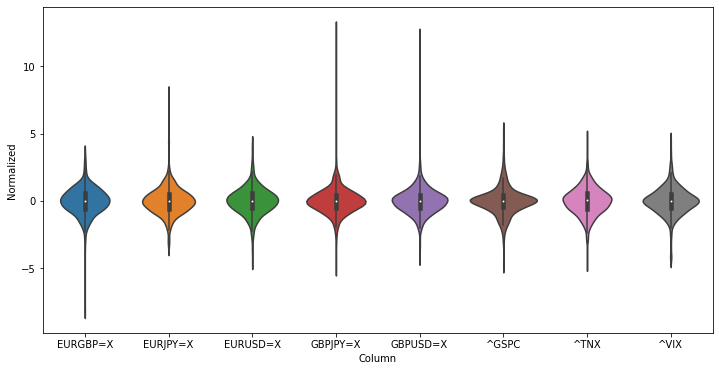

In [143]:
df_std = data_train_prod.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)

In [144]:
print(list(data_train_prod.columns))

['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', '^GSPC', '^TNX', '^VIX']


In [265]:
def window_data(data, window_size):
    last_index = len(data)-window_size
    
    trunc_data = [data[i:i+window_size] for i in range(last_index)]
    return np.dstack(trunc_data)
    
def gen_data(train, window, val, col=0, cls=False):
    val_data = train[-window:].append(val).values
    inputs = np.transpose(window_data(train.values, window), (2,0,1))
    labels = train.values[window:,col]
    val_inputs = np.transpose(window_data(val_data, window), (2,0,1))
    val_labels = val_data[window:,col]
    
    if cls==True:
        labels = labels > 0
        val_labels = val_labels > 0
        labels = labels.astype(int)
        val_labels = val_labels.astype(int)
    return (inputs,labels), (val_inputs, val_labels)

In [266]:
def run_wrapper(model, window, train, test, loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(1e-3), cls=False, truth_idx=0, verbose=0, epochs=50):
    tf.random.set_seed(1234)
    # if cls = True, runs HITS instead of MAE
    model.compile(loss=loss, optimizer=optimizer)
    if verbose:
        model.summary()
    
    train, val = gen_data(train, window, test, cls=cls, col=truth_idx)
    hist = model.fit(*train, epochs=epochs, verbose=0, validation_data=val)
    data = evaluate_model(model, hist, *train, *val, acc=cls)
    return data

In [411]:
def yearly_rolling_wrapper(build_model, window, start_year, end_year, cols, loss=tf.keras.losses.MeanAbsoluteError(), optimizer=tf.keras.optimizers.Adam(1e-3), cls=False, truth_idx=0, verbose=0, epochs=50):
    year_first = '-01-01'
    year_last = '-12-31'
    all_data = pd.DataFrame([])
    for i in range(end_year-start_year+1):
        tf.random.set_seed(1234)
        model = build_model()
        d1 = str(start_year + i) + year_first
        d2 = str(start_year + 2 + i) + year_last
        d3 = str(start_year + 3 + i) + year_first
        d4 = str(start_year + 3 + i) + year_last
        print(d1, d2, d3, d4)
        data_train, data_test = data_load(d1, d2, d3, d4)
        train = data_train.loc[:, cols]
        test = data_test.loc[:, cols]
        data = run_wrapper(model, window, train, test, loss, optimizer, cls, truth_idx, verbose, epochs)
        all_data = all_data.append(data, ignore_index=True)
    return all_data

## Index Forecasting (Conditional)

In [180]:
num_features=3
num_timesteps=1
lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(10, kernel_regularizer=tf.keras.regularizers.l2(0.001), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1)
])

In [181]:
idx_train = data_train_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]
idx_test = data_test_prod.loc[:, ['^GSPC', '^TNX', '^VIX']]

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 10)                560       
_________________________________________________________________
dropout_130 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


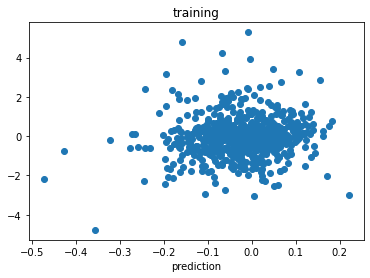

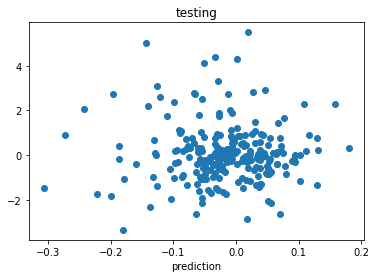

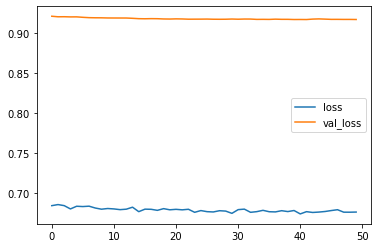

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.004346,1.247216,0.67 (0.72),0.73 (0.76)


In [182]:
window=1
lstm_model_1_data = run_wrapper(lstm_model_1, window, idx_train, idx_test, verbose=1)
lstm_model_1_data

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_132 (LSTM)              (None, 10)                560       
_________________________________________________________________
dropout_131 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


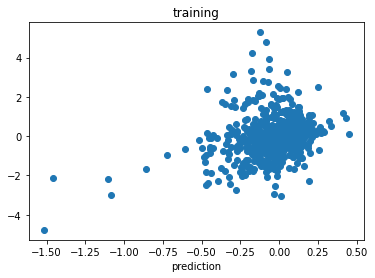

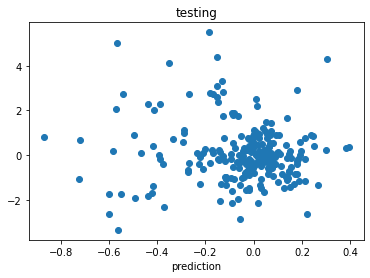

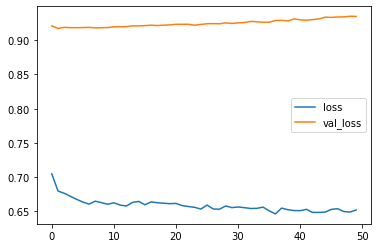

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.993952,1.247216,0.64 (0.71),0.75 (0.78)


In [183]:
window=16
lstm_model_16_data = run_wrapper(lstm_model_16, window, idx_train, idx_test, verbose=1)
lstm_model_16_data

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (None, 10)                560       
_________________________________________________________________
dropout_132 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


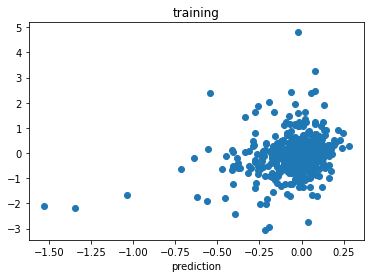

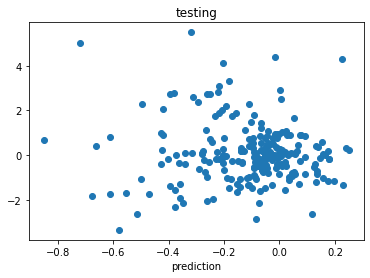

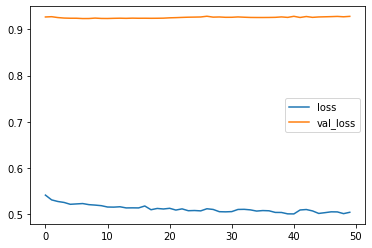

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.800016,1.247216,0.62 (0.70),0.74 (0.79)


In [184]:
window=256
lstm_model_256_data = run_wrapper(lstm_model_256, window, idx_train, idx_test, verbose=1)
lstm_model_256_data

## Index Forecasting (Unconditional)

## Index Forecasting Classification (Conditional)

In [185]:
num_features=3
num_timesteps=1
class_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

num_timesteps=16
class_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

num_timesteps=256
class_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

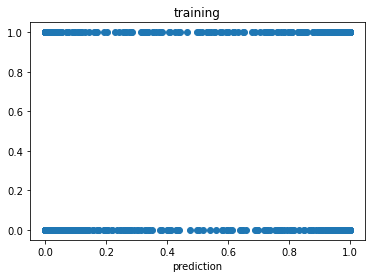

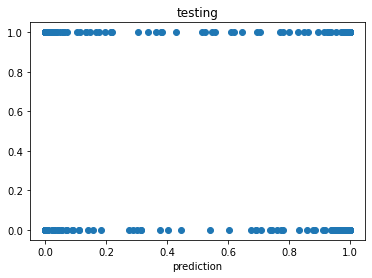

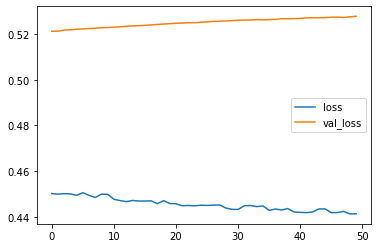

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.460251,0.518987,0.570432,0.472574


In [192]:
window=1
class_lstm_model_1_data = run_wrapper(class_lstm_model_1, window, idx_train, idx_test, cls=True)
class_lstm_model_1_data

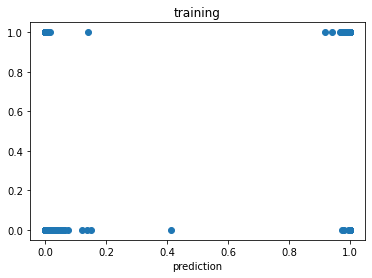

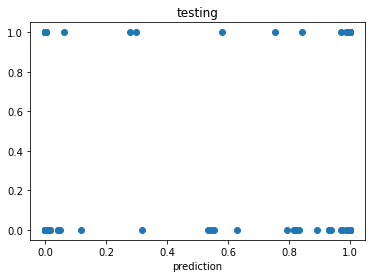

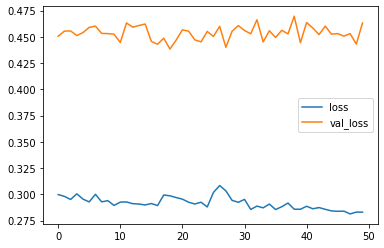

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.458689,0.518987,0.722222,0.527426


In [193]:
window=16
class_lstm_model_16_data = run_wrapper(class_lstm_model_16, window, idx_train, idx_test, cls=True)
class_lstm_model_16_data

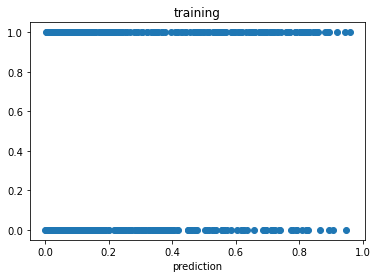

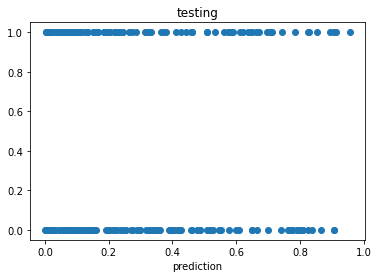

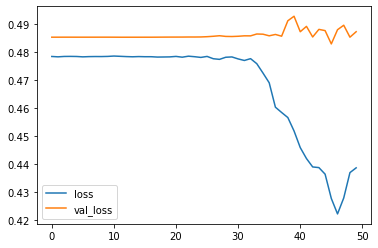

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.463203,0.518987,0.606061,0.531646


In [194]:
window=256
class_lstm_model_256_data = run_wrapper(class_lstm_model_256, window, idx_train, idx_test, cls=True)
class_lstm_model_256_data

## Index Forecasting Classification (Unconditional)

## Exchange Rate Forecasting (Conditional)

In [195]:
num_features=5
num_timesteps=1
er_lstm_model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=16
er_lstm_model_16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

num_timesteps=256
er_lstm_model_256 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(num_timesteps, num_features)),
    tf.keras.layers.LSTM(25, return_sequences=False),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])

In [196]:
er_columns = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_train = data_train_prod.loc[:, er_columns]
er_test = data_test_prod.loc[:, er_columns]

In [197]:
er_test.diff().abs().mean()

EURGBP=X    0.646606
EURJPY=X    0.858760
EURUSD=X    0.844043
GBPJPY=X    0.819481
GBPUSD=X    0.883561
dtype: float64

EURGBP=X


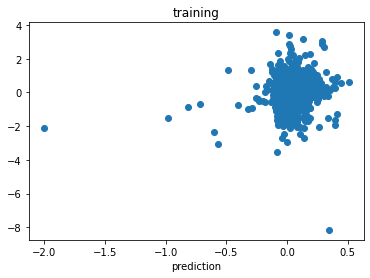

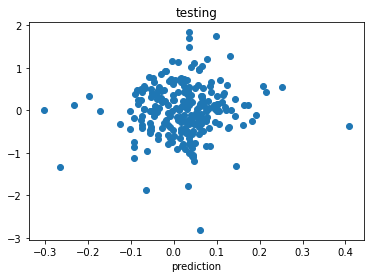

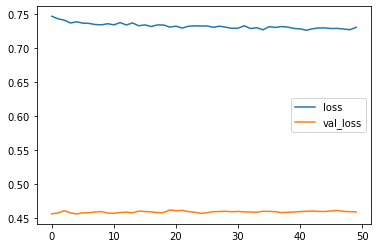

EURJPY=X


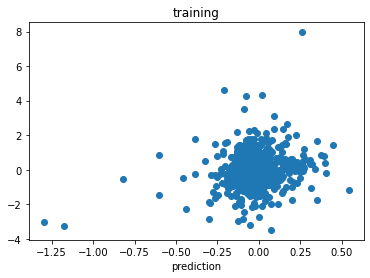

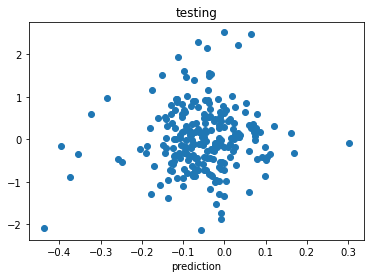

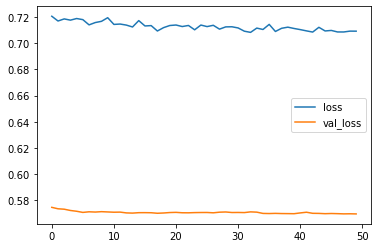

EURUSD=X


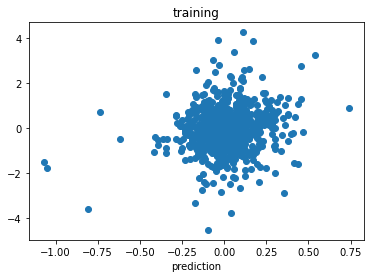

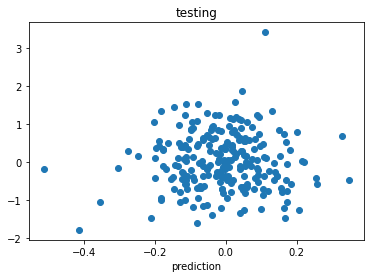

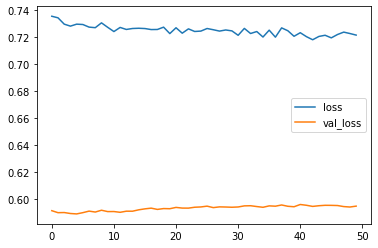

GBPJPY=X


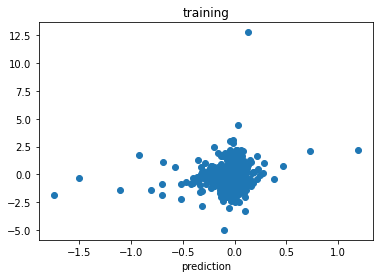

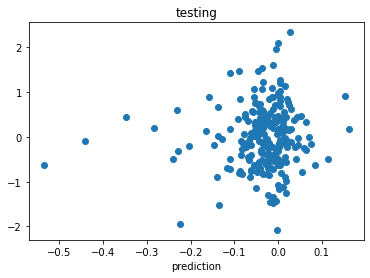

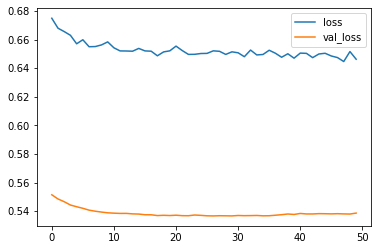

GBPUSD=X


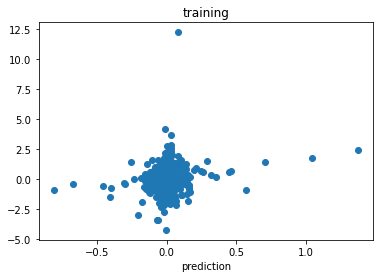

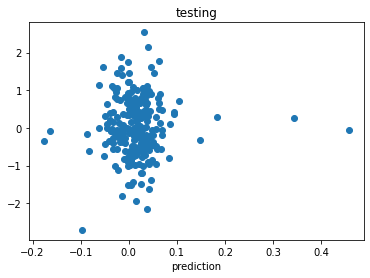

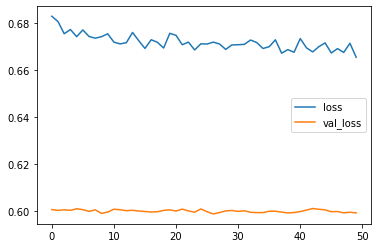

In [198]:
window=1
er_lstm_model_1_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_1, window, er_train, er_test, truth_idx=i)
    er_lstm_model_1_data = er_lstm_model_1_data.append(data)
    
er_lstm_model_1_data.index = [er_columns[i] for i in range(5)]

In [199]:
er_lstm_model_1_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.062889,0.646606,0.68 (0.63),0.71 (0.62)
EURJPY=X,1.075619,0.858760,0.66 (0.63),0.66 (0.58)
EURUSD=X,1.092993,0.844043,0.66 (0.61),0.70 (0.53)
GBPJPY=X,0.959938,0.819481,0.67 (0.77),0.66 (0.53)
GBPUSD=X,0.993231,0.883561,0.67 (0.73),0.68 (0.55)


EURGBP=X


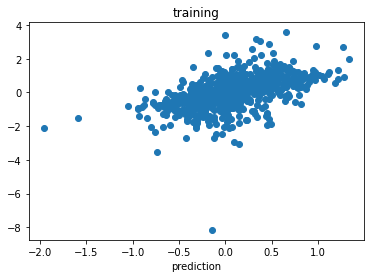

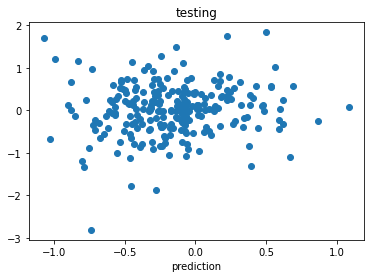

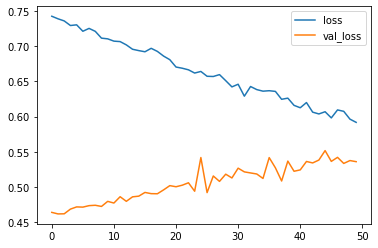

EURJPY=X


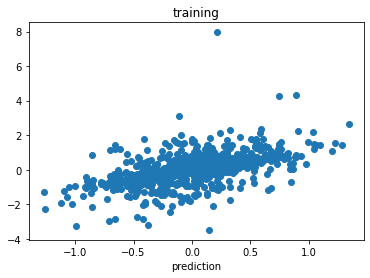

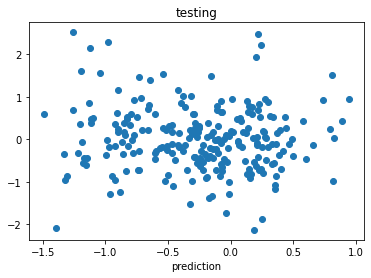

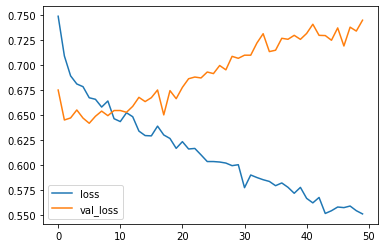

EURUSD=X


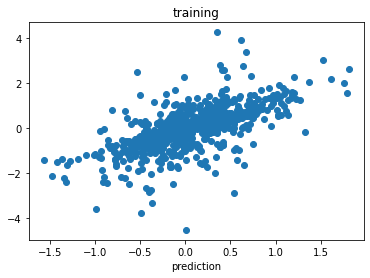

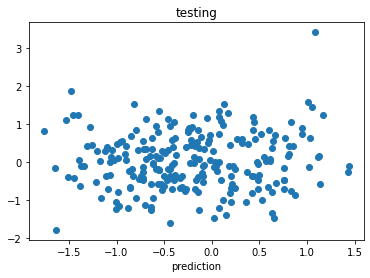

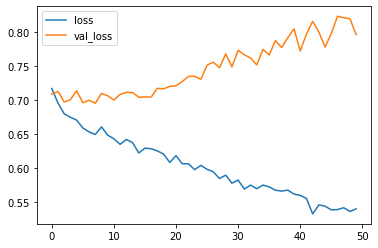

GBPJPY=X


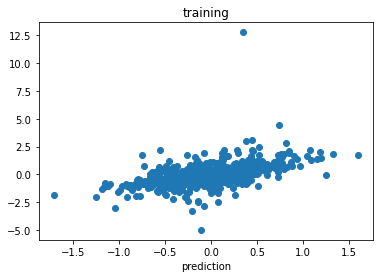

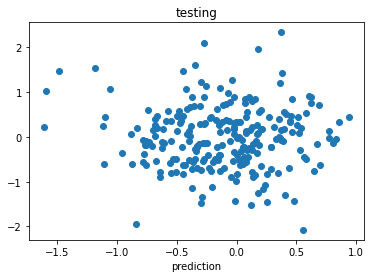

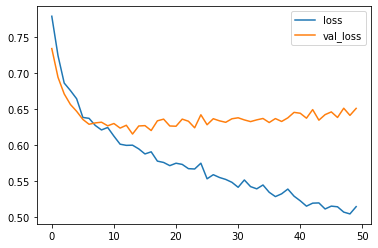

GBPUSD=X


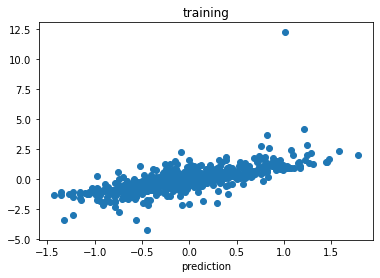

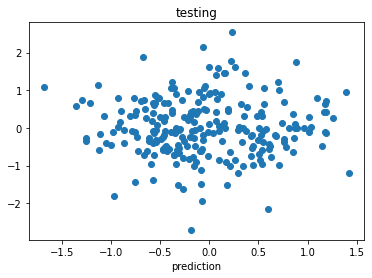

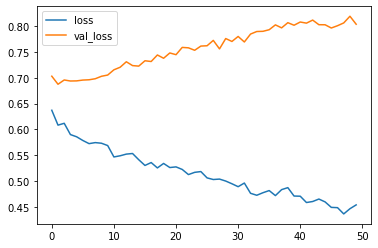

In [200]:
window=16
er_lstm_model_16_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_16, window, er_train, er_test, truth_idx=i)
    er_lstm_model_16_data = er_lstm_model_16_data.append(data)
    
er_lstm_model_16_data.index = [er_columns[i] for i in range(5)]


In [201]:
er_lstm_model_16_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.065658,0.646606,0.54 (0.59),0.83 (0.71)
EURJPY=X,1.055305,0.858760,0.49 (0.59),0.87 (0.74)
EURUSD=X,1.082116,0.844043,0.46 (0.53),0.94 (0.71)
GBPJPY=X,0.952392,0.819481,0.50 (0.73),0.79 (0.67)
GBPUSD=X,0.995971,0.883561,0.40 (0.61),0.91 (0.64)


EURGBP=X


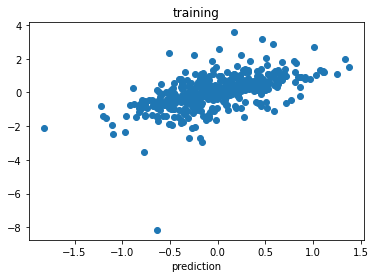

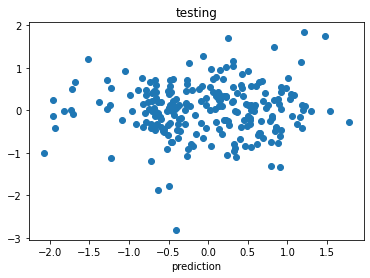

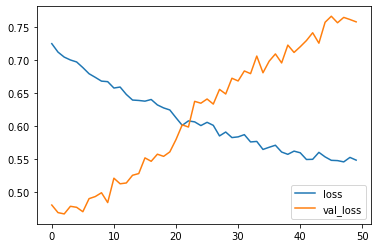

EURJPY=X


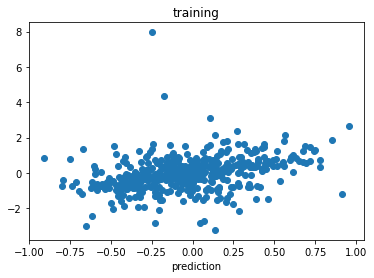

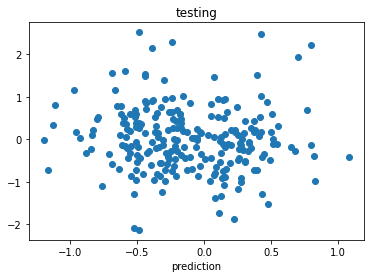

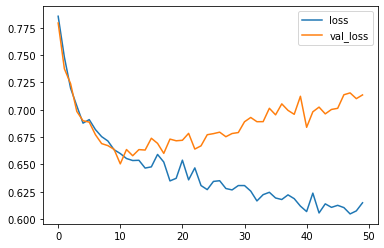

EURUSD=X


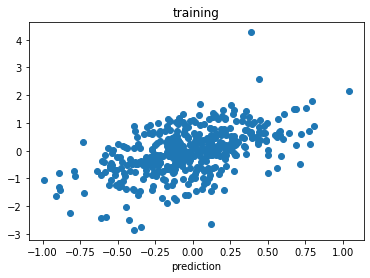

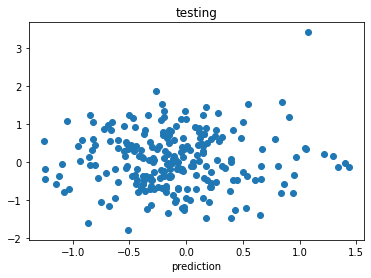

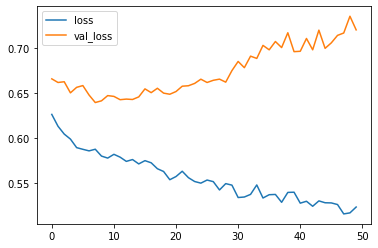

GBPJPY=X


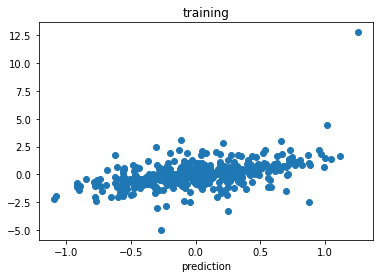

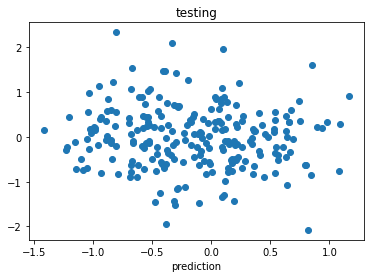

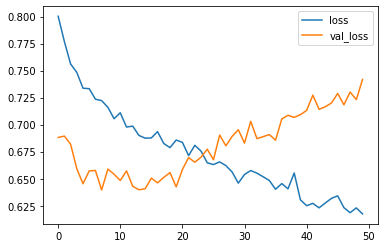

GBPUSD=X


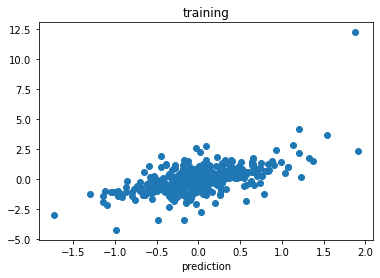

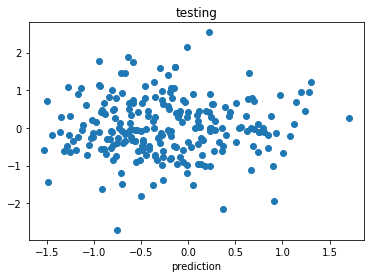

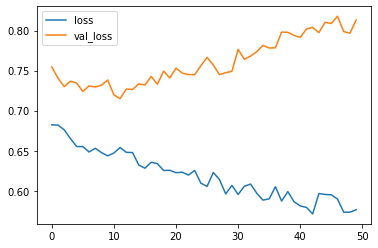

In [202]:
window=256
er_lstm_model_256_data = pd.DataFrame([])
for i in range(5):
    print(er_columns[i])
    data = run_wrapper(er_lstm_model_256, window, er_train, er_test, truth_idx=i)
    er_lstm_model_256_data = er_lstm_model_256_data.append(data)
    
er_lstm_model_256_data.index = [er_columns[i] for i in range(5)]


In [203]:
er_lstm_model_256_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.061233,0.646606,0.49 (0.59),1.17 (0.84)
EURJPY=X,1.043163,0.858760,0.57 (0.66),0.83 (0.65)
EURUSD=X,0.941678,0.844043,0.53 (0.52),0.85 (0.61)
GBPJPY=X,1.099582,0.819481,0.55 (0.74),0.91 (0.68)
GBPUSD=X,1.076672,0.883561,0.51 (0.66),0.92 (0.69)


## Experimentation

### S&P Regression

Model: "sequential_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_291 (LSTM)              (None, 16, 5)             180       
_________________________________________________________________
dropout_290 (Dropout)        (None, 16, 5)             0         
_________________________________________________________________
lstm_292 (LSTM)              (None, 5)                 220       
_________________________________________________________________
dropout_291 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 6         
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


<Figure size 432x288 with 0 Axes>

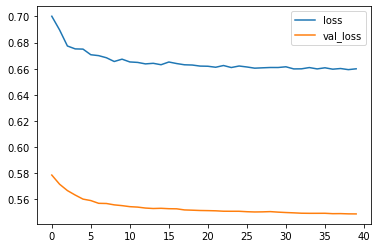

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.005709,0.816012,0.65 (0.76),0.67 (0.68)


In [413]:
def sp_regress_16():
    num_timesteps=16
    num_features=3
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_timesteps, num_features)),
        tf.keras.layers.LSTM(5, kernel_regularizer=tf.keras.regularizers.l1(0.001), return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(5, kernel_regularizer=tf.keras.regularizers.l1(0.001), return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1)
    ])
    return model

lstm_model_16_add_layers = sp_regress_16()

window=16
lstm_model_16_add_layers_data = run_wrapper(lstm_model_16_add_layers, window, idx_train, idx_test, verbose=1, epochs=40)
lstm_model_16_add_layers_data

In [405]:
# Original data
lstm_model_16_data

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,0.993952,1.247216,0.64 (0.71),0.75 (0.78)


1. Three layers has higher starting validation error but converges to same point
2. Increasing dropout has smoother validation loss function but converges to same loss
3. Changing to l1 regularization speeds up training significantly
4. Changing loss function to MSE worsens performance
5. Increasing number of LSTM cells from 10 - 25 does not change performance
6. SGD, adagrad optimizers did not converge.

Overall, it seems like this is as much information as can be captured in the data, as the differences from changing hyperparameters or network architecture are small

### More Date Ranges

2009-01-01 2011-12-31 2012-01-01 2012-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

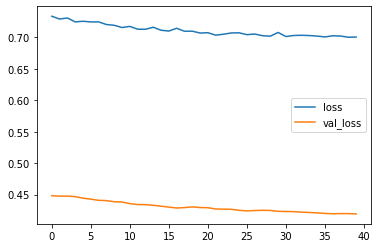

2010-01-01 2012-12-31 2013-01-01 2013-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

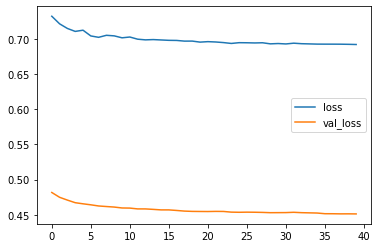

2011-01-01 2013-12-31 2014-01-01 2014-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

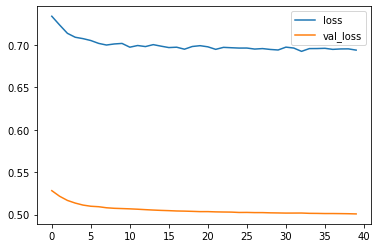

2012-01-01 2014-12-31 2015-01-01 2015-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

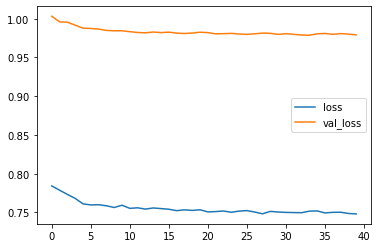

2013-01-01 2015-12-31 2016-01-01 2016-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

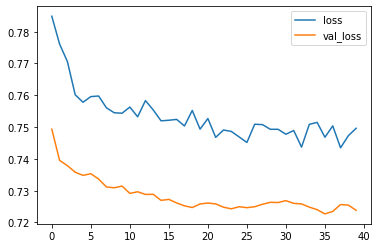

2014-01-01 2016-12-31 2017-01-01 2017-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

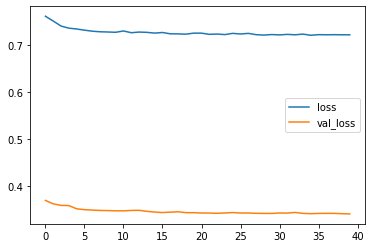

2015-01-01 2017-12-31 2018-01-01 2018-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

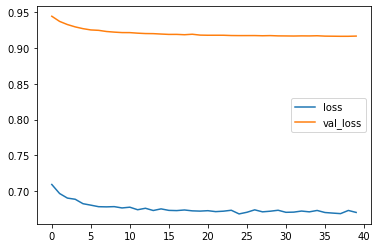

2016-01-01 2018-12-31 2019-01-01 2019-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

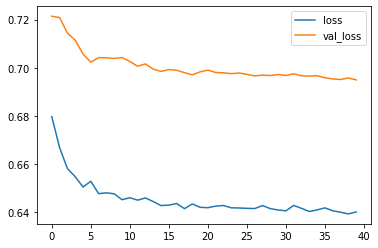

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.047777,0.614189,0.66 (0.67),0.67 (0.61)
1,1.048846,0.673409,0.66 (0.69),0.67 (0.55)
2,1.034491,0.749039,0.67 (0.71),0.66 (0.63)
3,1.122686,1.371315,0.66 (0.60),0.71 (0.65)
4,1.082464,1.093515,0.68 (0.63),0.66 (0.67)
5,1.054195,0.520765,0.68 (0.66),0.65 (0.67)
6,0.993952,1.247216,0.67 (0.73),0.73 (0.76)
7,0.923359,1.029948,0.69 (0.79),0.67 (0.69)


In [414]:
window=16
cols = ['^GSPC', '^TNX', '^VIX']
lstm_model_16_rolling_data = yearly_rolling_wrapper(sp_regress_16, window, 2009, 2016, cols, verbose=0, epochs=40)
lstm_model_16_rolling_data

In [415]:
lstm_model_16_rolling_data = lstm_model_16_rolling_data.append(lstm_model_16_rolling_data.mean(), 'Mean')
lstm_model_16_rolling_data = lstm_model_16_rolling_data.append(lstm_model_16_rolling_data.std(), 'Std')
lstm_model_16_rolling_data.index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
lstm_model_16_rolling_data.columns = ['Naive(Train)', 'Naive(Val)', 'MASE-Train(Std)', 'MASE-Val(Std)']
lstm_model_16_rolling_data.round(3)

,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.048,0.614,0.66 (0.67),0.67 (0.61)
2013,1.049,0.673,0.66 (0.69),0.67 (0.55)
2014,1.034,0.749,0.67 (0.71),0.66 (0.63)
2015,1.123,1.371,0.66 (0.60),0.71 (0.65)
2016,1.082,1.094,0.68 (0.63),0.66 (0.67)
2017,1.054,0.521,0.68 (0.66),0.65 (0.67)
2018,0.994,1.247,0.67 (0.73),0.73 (0.76)
2019,0.923,1.030,0.69 (0.79),0.67 (0.69)
Mean,1.038,0.912,NaN,NaN
Std,0.056,0.295,NaN,NaN


In [416]:
temp = lstm_model_16_rolling_data.iloc[:-2, 2:]
for col in temp:
    data = temp[col].values
    m = np.mean([float(d[:5]) for d in data])
    std = np.std([float(d[:5]) for d in data])
    lstm_model_16_rolling_data.loc['Mean', col] = np.round(m, 3)
    lstm_model_16_rolling_data.loc['Std', col] = np.round(std, 3)

lstm_model_16_rolling_data.round(3)
    

,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.048,0.614,0.66 (0.67),0.67 (0.61)
2013,1.049,0.673,0.66 (0.69),0.67 (0.55)
2014,1.034,0.749,0.67 (0.71),0.66 (0.63)
2015,1.123,1.371,0.66 (0.60),0.71 (0.65)
2016,1.082,1.094,0.68 (0.63),0.66 (0.67)
2017,1.054,0.521,0.68 (0.66),0.65 (0.67)
2018,0.994,1.247,0.67 (0.73),0.73 (0.76)
2019,0.923,1.030,0.69 (0.79),0.67 (0.69)
Mean,1.038,0.912,0.671,0.678
Std,0.056,0.295,0.011,0.026


In [417]:
lstm_model_16_rolling_data.index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
lstm_model_16_rolling_data.round(3)

,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.048,0.614,0.66 (0.67),0.67 (0.61)
2013,1.049,0.673,0.66 (0.69),0.67 (0.55)
2014,1.034,0.749,0.67 (0.71),0.66 (0.63)
2015,1.123,1.371,0.66 (0.60),0.71 (0.65)
2016,1.082,1.094,0.68 (0.63),0.66 (0.67)
2017,1.054,0.521,0.68 (0.66),0.65 (0.67)
2018,0.994,1.247,0.67 (0.73),0.73 (0.76)
2019,0.923,1.030,0.69 (0.79),0.67 (0.69)
Mean,1.038,0.912,0.671,0.678
Std,0.056,0.295,0.011,0.026


### S&P Classification

In [206]:
# Original Data
# class_lstm_model_16 = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(num_timesteps, num_features)),
#     tf.keras.layers.LSTM(25, return_sequences=False),
#     tf.keras.layers.Dropout(0.1),
#     tf.keras.layers.Dense(units=1, activation='sigmoid')
# ])
class_lstm_model_16_data

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.458689,0.518987,0.722222,0.527426


<Figure size 432x288 with 0 Axes>

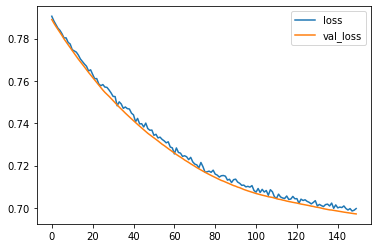

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.474227,0.53527,0.547865,0.560166


In [390]:
def build_class_16():
    num_timesteps=16
    num_features=3
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_timesteps, num_features)),
        tf.keras.layers.LSTM(5, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(5, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(25, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    return model

class_lstm_model_16_add_layers = build_class_16()
window=16
class_lstm_model_16_data_add_layers = run_wrapper(class_lstm_model_16_add_layers, window, 
                                           idx_train, idx_test,
                                            optimizer=tf.keras.optimizers.Adam(1e-4),
                                            loss=tf.keras.losses.BinaryCrossentropy(),
                                            epochs=150,
                                           cls=True)
class_lstm_model_16_data_add_layers 

1. Lowering learning rate to 1e-4 showed better loss behavior, however worse HITS, perhaps MAE not best loss function for this task.
2. Changing loss to BinaryCrossEntropy(), Mean Squared Error, shows overfitting, poor performance
3. Adding Regularization (Dropout- , l2-regularization). l1-regularization significantly improved loss and performance.
4. Lowering number of LSTM cells improved performance
5. Additional layers X performance
3. Testing "best" architecture for regression seems to have poorer performance

2009-01-01 2011-12-31 2012-01-01 2012-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

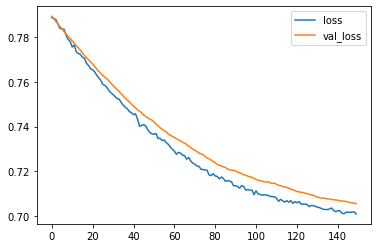

2010-01-01 2012-12-31 2013-01-01 2013-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

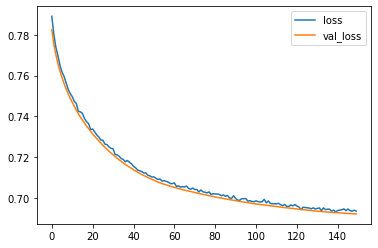

2011-01-01 2013-12-31 2014-01-01 2014-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

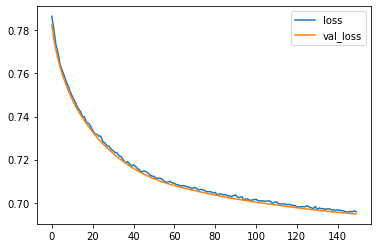

2012-01-01 2014-12-31 2015-01-01 2015-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

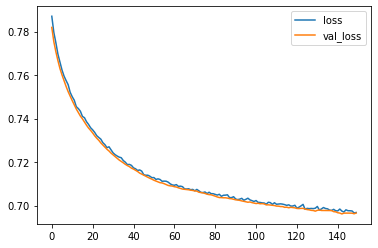

2013-01-01 2015-12-31 2016-01-01 2016-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

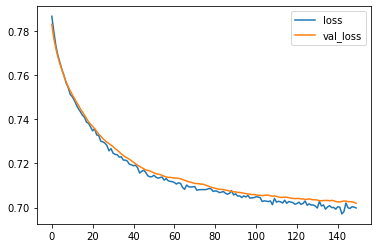

2014-01-01 2016-12-31 2017-01-01 2017-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

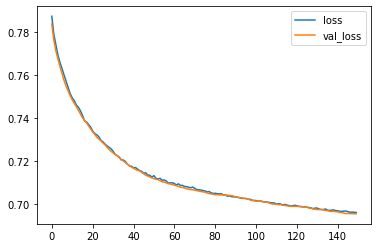

2015-01-01 2017-12-31 2018-01-01 2018-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

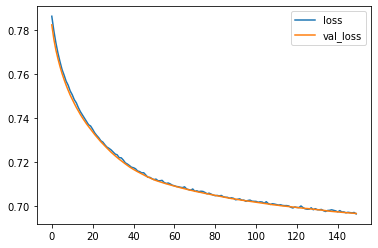

2016-01-01 2018-12-31 2019-01-01 2019-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

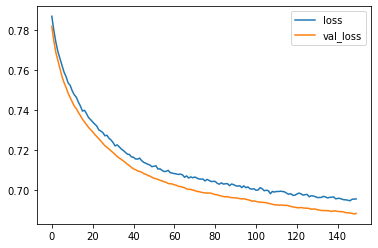

,Naive (Train),Naive (Test),HITS (Train),HITS (Val)
0,0.494334,0.525641,0.532578,0.482906
1,0.508571,0.421941,0.530000,0.540084
2,0.492109,0.451883,0.519369,0.531381
3,0.470588,0.458678,0.538020,0.549587
4,0.452482,0.456067,0.547518,0.531381
5,0.457507,0.474576,0.502833,0.559322
6,0.458689,0.518987,0.509972,0.514768
7,0.484935,0.520930,0.523673,0.595349


In [391]:
window=16
cols = ['^GSPC', '^TNX', '^VIX']
class_lstm_model_16_rolling_data = yearly_rolling_wrapper(build_class_16, 
                                                          window, 2009, 2016, cols, 
                                                          optimizer=tf.keras.optimizers.Adam(1e-4), 
                                                          loss=tf.keras.losses.BinaryCrossentropy(), 
                                                          verbose=0, epochs=150, cls=True)
class_lstm_model_16_rolling_data

In [403]:
class_lstm_model_16_rolling_data = class_lstm_model_16_rolling_data.append(class_lstm_model_16_rolling_data.mean(), 'Mean')
class_lstm_model_16_rolling_data = class_lstm_model_16_rolling_data.append(class_lstm_model_16_rolling_data.std(), 'Std')
class_lstm_model_16_rolling_data.index = [2012 +
                                          i for i in range(8)] + ['Mean'] + ['Std']

In [318]:
class_lstm_model_16_add_layers.summary()

Model: "sequential_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_186 (LSTM)              (None, 16, 5)             180       
_________________________________________________________________
dropout_185 (Dropout)        (None, 16, 5)             0         
_________________________________________________________________
lstm_187 (LSTM)              (None, 16, 5)             220       
_________________________________________________________________
dropout_186 (Dropout)        (None, 16, 5)             0         
_________________________________________________________________
lstm_188 (LSTM)              (None, 25)                3100      
_________________________________________________________________
dropout_187 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 1)              

In [398]:
class_lstm_model_16_rolling_data.columns = ['Naive(Train)', 'Naive(Val)', 'HITS(Train)', 'HITS(Val)']
class_lstm_model_16_rolling_data.round(3)

,Naive(Train),Naive(Val),HITS(Train),HITS(Val)
2012,0.494,0.526,0.533,0.483
2013,0.509,0.422,0.530,0.540
2014,0.492,0.452,0.519,0.531
2015,0.471,0.459,0.538,0.550
2016,0.452,0.456,0.548,0.531
2017,0.458,0.475,0.503,0.559
2018,0.459,0.519,0.510,0.515
2019,0.485,0.521,0.524,0.595
Mean,0.477,0.479,0.525,0.538
Std,0.019,0.036,0.014,0.031


## Exchange Rate Regression

1. l1 regularization improved performance
2. 
3. 
4. 
5. 

EURGBP=X


<Figure size 432x288 with 0 Axes>

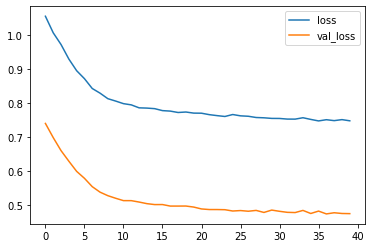

EURJPY=X


<Figure size 432x288 with 0 Axes>

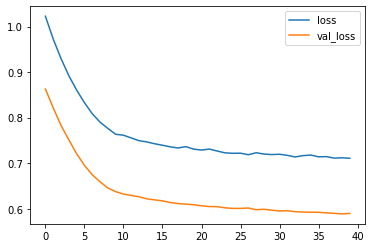

EURUSD=X


<Figure size 432x288 with 0 Axes>

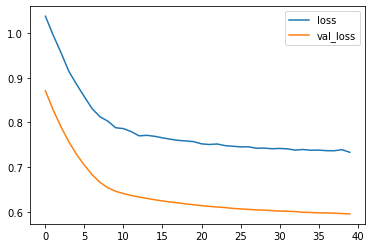

GBPJPY=X


<Figure size 432x288 with 0 Axes>

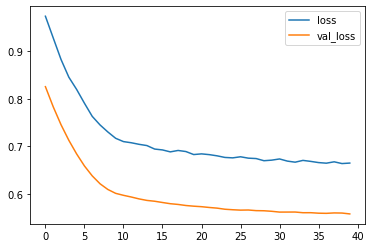

GBPUSD=X


<Figure size 432x288 with 0 Axes>

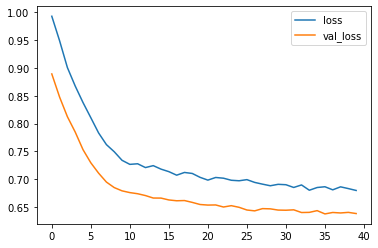

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.065658,0.646606,0.69 (0.62),0.72 (0.61)
EURJPY=X,1.055305,0.858760,0.66 (0.63),0.67 (0.59)
EURUSD=X,1.082116,0.844043,0.67 (0.61),0.69 (0.53)
GBPJPY=X,0.952392,0.819481,0.68 (0.79),0.66 (0.53)
GBPUSD=X,0.995971,0.883561,0.66 (0.74),0.70 (0.55)


In [422]:
def build_er_model():
    num_timesteps=16
    num_features=5
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_timesteps, num_features)),
        tf.keras.layers.LSTM(25, 
                             kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(25, kernel_regularizer=tf.keras.regularizers.l1(.001), 
                             return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=1)
    ])
    return model

window=16
er_lstm_model_16_data_ex = pd.DataFrame([])
num_to_plot = 5
for i in range(num_to_plot):
    print(er_columns[i])
    er_lstm_model_16_ex = build_er_model()
    data = run_wrapper(er_lstm_model_16_ex, window, er_train, er_test, truth_idx=i,
                      optimizer=tf.keras.optimizers.Adam(1e-3), epochs=40)
    er_lstm_model_16_data_ex = er_lstm_model_16_data_ex.append(data)
    
er_lstm_model_16_data_ex.index = [er_columns[i] for i in range(num_to_plot)]
er_lstm_model_16_data_ex


In [423]:
# Saved Model
# er_lstm_model_16_ex = tf.keras.models.Sequential([
#     tf.keras.layers.Input(shape=(num_timesteps, num_features)),
#     tf.keras.layers.LSTM(10, 
#                          kernel_regularizer=tf.keras.regularizers.l2(.001), 
#                          return_sequences=True),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.LSTM(15, kernel_regularizer=tf.keras.regularizers.l2(.001), 
#                          return_sequences=False),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(units=1)
# ])
er_lstm_model_16_ex.summary()

Model: "sequential_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_325 (LSTM)              (None, 16, 25)            3100      
_________________________________________________________________
dropout_324 (Dropout)        (None, 16, 25)            0         
_________________________________________________________________
lstm_326 (LSTM)              (None, 25)                5100      
_________________________________________________________________
dropout_325 (Dropout)        (None, 25)                0         
_________________________________________________________________
dense_203 (Dense)            (None, 1)                 26        
Total params: 8,226
Trainable params: 8,226
Non-trainable params: 0
_________________________________________________________________


In [424]:
er_lstm_model_16_data_ex

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
EURGBP=X,1.065658,0.646606,0.69 (0.62),0.72 (0.61)
EURJPY=X,1.055305,0.858760,0.66 (0.63),0.67 (0.59)
EURUSD=X,1.082116,0.844043,0.67 (0.61),0.69 (0.53)
GBPJPY=X,0.952392,0.819481,0.68 (0.79),0.66 (0.53)
GBPUSD=X,0.995971,0.883561,0.66 (0.74),0.70 (0.55)


EURGBP=X
2009-01-01 2011-12-31 2012-01-01 2012-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

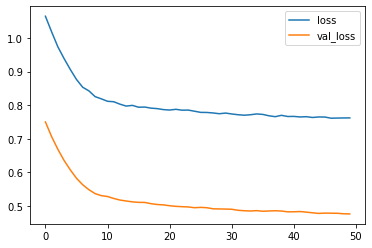

2010-01-01 2012-12-31 2013-01-01 2013-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

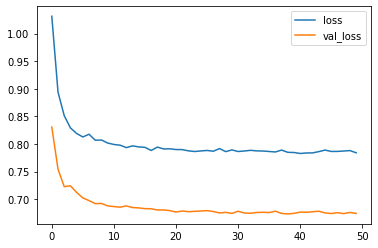

2011-01-01 2013-12-31 2014-01-01 2014-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

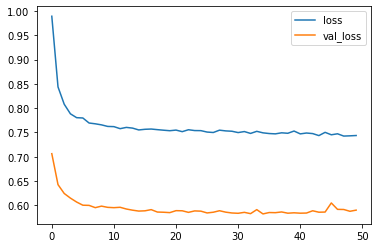

2012-01-01 2014-12-31 2015-01-01 2015-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

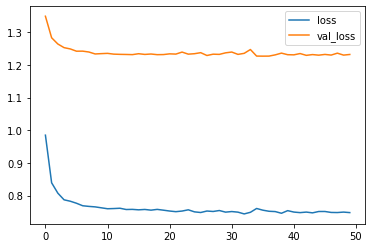

2013-01-01 2015-12-31 2016-01-01 2016-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

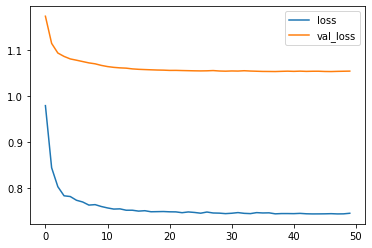

2014-01-01 2016-12-31 2017-01-01 2017-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

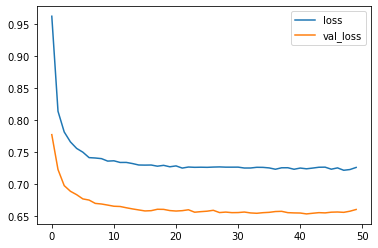

2015-01-01 2017-12-31 2018-01-01 2018-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

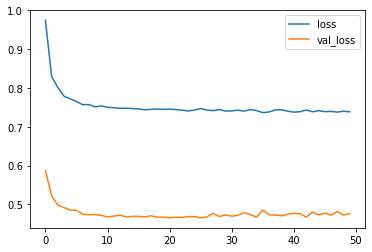

2016-01-01 2018-12-31 2019-01-01 2019-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

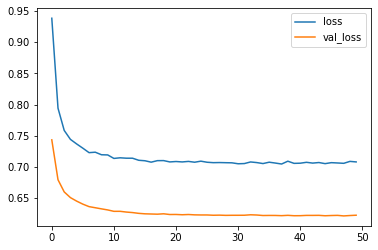

EURJPY=X
2009-01-01 2011-12-31 2012-01-01 2012-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

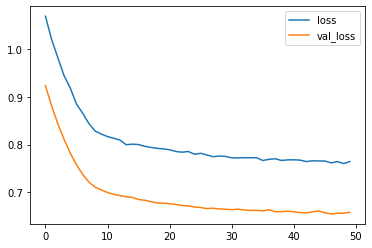

2010-01-01 2012-12-31 2013-01-01 2013-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

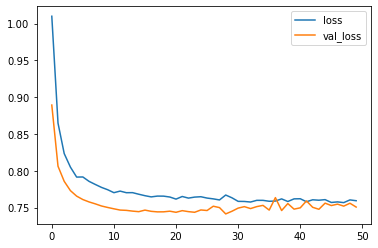

2011-01-01 2013-12-31 2014-01-01 2014-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

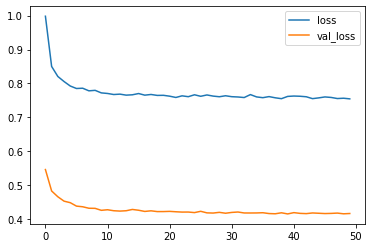

2012-01-01 2014-12-31 2015-01-01 2015-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

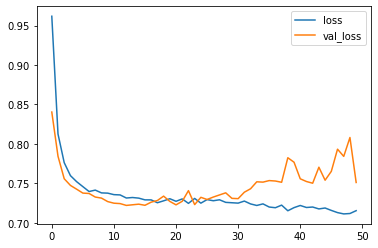

2013-01-01 2015-12-31 2016-01-01 2016-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

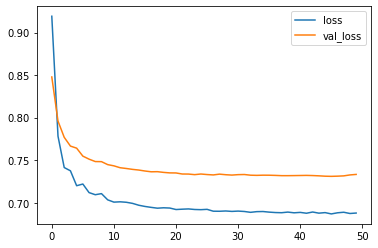

2014-01-01 2016-12-31 2017-01-01 2017-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

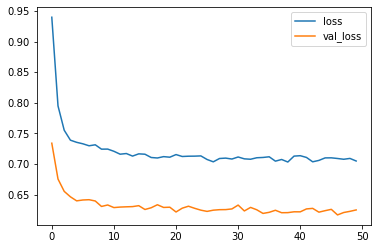

2015-01-01 2017-12-31 2018-01-01 2018-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

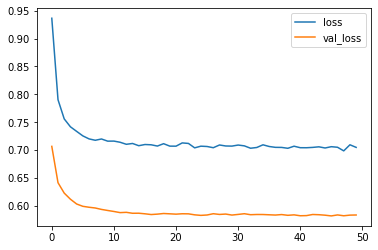

2016-01-01 2018-12-31 2019-01-01 2019-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

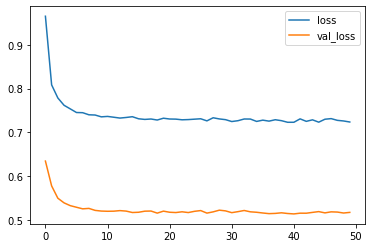

EURUSD=X
2009-01-01 2011-12-31 2012-01-01 2012-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

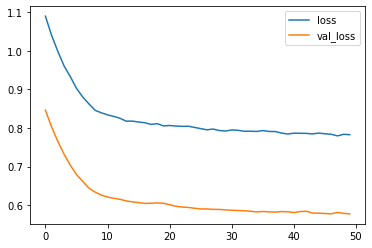

2010-01-01 2012-12-31 2013-01-01 2013-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

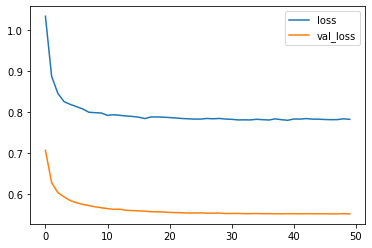

2011-01-01 2013-12-31 2014-01-01 2014-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

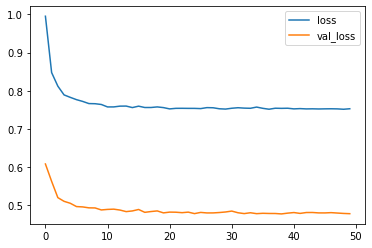

2012-01-01 2014-12-31 2015-01-01 2015-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

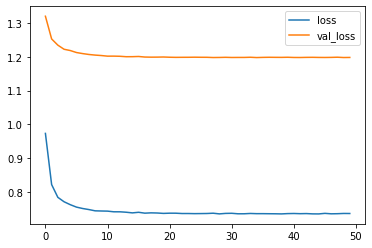

2013-01-01 2015-12-31 2016-01-01 2016-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

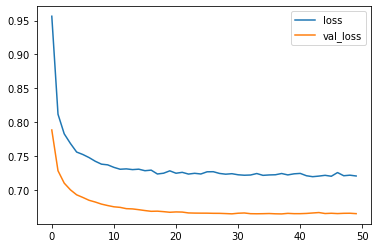

2014-01-01 2016-12-31 2017-01-01 2017-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

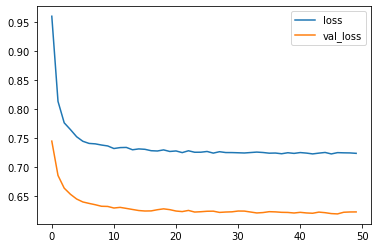

2015-01-01 2017-12-31 2018-01-01 2018-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

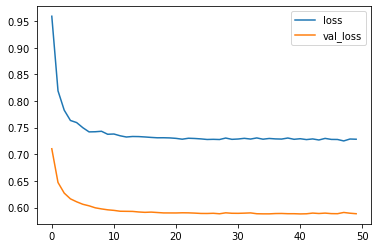

2016-01-01 2018-12-31 2019-01-01 2019-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

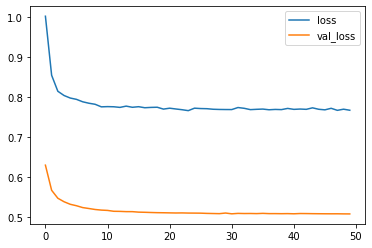

GBPJPY=X
2009-01-01 2011-12-31 2012-01-01 2012-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

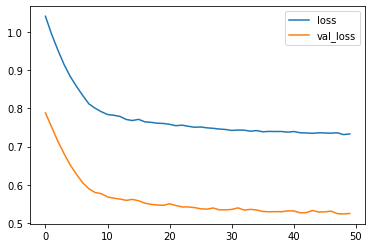

2010-01-01 2012-12-31 2013-01-01 2013-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

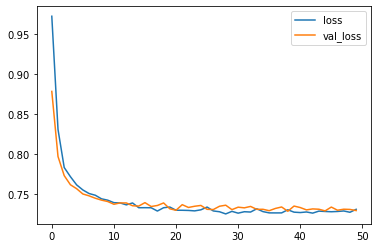

2011-01-01 2013-12-31 2014-01-01 2014-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

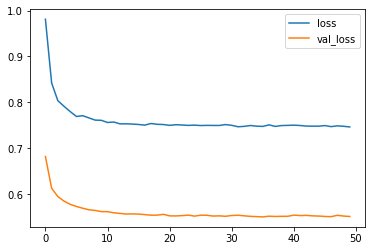

2012-01-01 2014-12-31 2015-01-01 2015-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

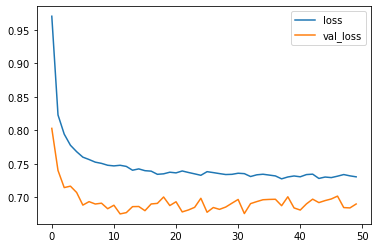

2013-01-01 2015-12-31 2016-01-01 2016-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

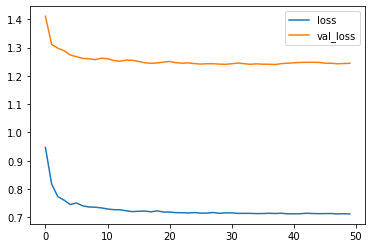

2014-01-01 2016-12-31 2017-01-01 2017-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

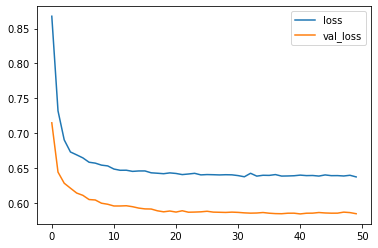

2015-01-01 2017-12-31 2018-01-01 2018-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

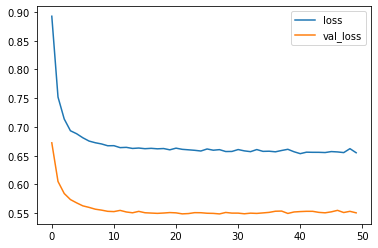

2016-01-01 2018-12-31 2019-01-01 2019-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

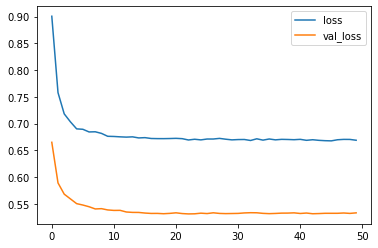

GBPUSD=X
2009-01-01 2011-12-31 2012-01-01 2012-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

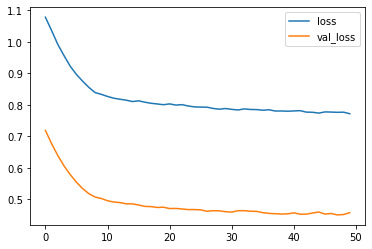

2010-01-01 2012-12-31 2013-01-01 2013-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

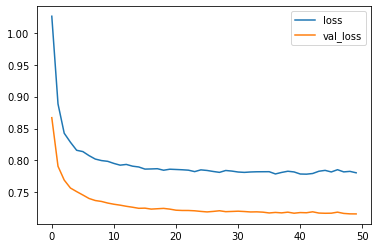

2011-01-01 2013-12-31 2014-01-01 2014-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

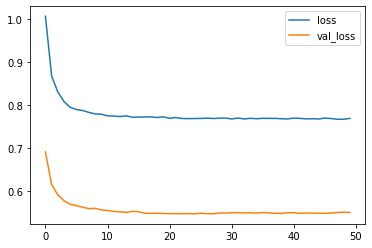

2012-01-01 2014-12-31 2015-01-01 2015-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

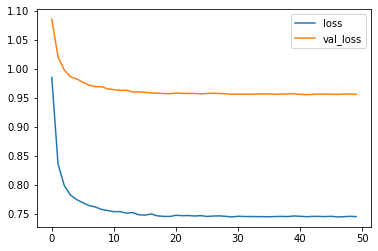

2013-01-01 2015-12-31 2016-01-01 2016-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

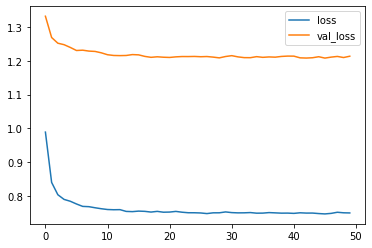

2014-01-01 2016-12-31 2017-01-01 2017-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

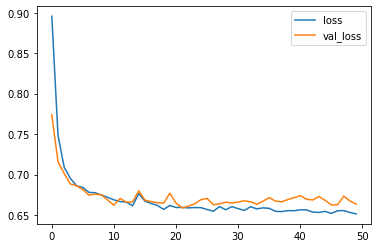

2015-01-01 2017-12-31 2018-01-01 2018-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

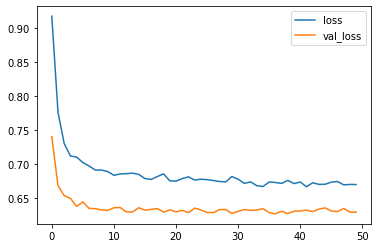

2016-01-01 2018-12-31 2019-01-01 2019-12-31
[*********************100%***********************]  8 of 8 completed


<Figure size 432x288 with 0 Axes>

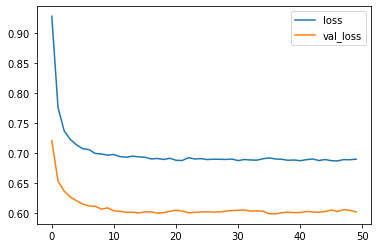

,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.045339,0.659745,0.71 (0.58),0.70 (0.55)
1,1.091698,1.016944,0.71 (0.57),0.66 (0.59)
2,1.097588,0.865512,0.66 (0.58),0.67 (0.59)
3,1.110861,1.647130,0.67 (0.59),0.74 (0.60)
4,1.078252,1.547346,0.69 (0.62),0.68 (0.66)
5,1.036269,0.959797,0.70 (0.68),0.68 (0.56)
6,1.065658,0.646606,0.69 (0.63),0.73 (0.61)
7,1.031517,0.875839,0.68 (0.68),0.71 (0.70)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.096920,0.917230,0.68 (0.59),0.70 (0.53)
1,1.113132,1.115073,0.67 (0.59),0.67 (0.63)
2,1.131096,0.595842,0.66 (0.59),0.69 (0.65)
3,1.076418,1.052521,0.66 (0.64),0.71 (0.66)
4,1.022818,1.084531,0.67 (0.67),0.67 (0.69)
5,1.039958,0.913952,0.67 (0.69),0.67 (0.55)
6,1.055305,0.858760,0.66 (0.63),0.67 (0.60)
7,1.091656,0.712478,0.65 (0.64),0.72 (0.75)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.103829,0.815593,0.70 (0.56),0.69 (0.54)
1,1.106247,0.875483,0.70 (0.58),0.63 (0.56)
2,1.124170,0.714611,0.67 (0.58),0.66 (0.63)
3,1.125666,1.704232,0.65 (0.58),0.70 (0.60)
4,1.079033,0.992221,0.66 (0.64),0.67 (0.62)
5,1.065520,0.946606,0.68 (0.66),0.66 (0.52)
6,1.082116,0.844043,0.67 (0.61),0.69 (0.52)
7,1.150584,0.696528,0.67 (0.55),0.73 (0.64)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.074631,0.732075,0.67 (0.61),0.70 (0.59)
1,1.080595,1.039338,0.67 (0.62),0.70 (0.64)
2,1.097328,0.781560,0.68 (0.61),0.70 (0.70)
3,1.062948,0.914000,0.68 (0.65),0.75 (0.65)
4,1.013390,1.797029,0.70 (0.67),0.69 (0.80)
5,0.912444,0.865889,0.70 (0.84),0.67 (0.58)
6,0.952392,0.819481,0.68 (0.79),0.66 (0.53)
7,0.992232,0.732156,0.67 (0.75),0.72 (0.79)


,Naive (Train),Naive (Test),MASE (Train),MASE (Val)
0,1.103403,0.619032,0.69 (0.55),0.72 (0.58)
1,1.137626,1.101885,0.68 (0.55),0.65 (0.54)
2,1.148726,0.793945,0.67 (0.55),0.69 (0.66)
3,1.113093,1.374670,0.67 (0.60),0.69 (0.59)
4,1.111962,1.739781,0.67 (0.60),0.70 (0.82)
5,0.953847,0.978817,0.67 (0.79),0.67 (0.62)
6,0.995971,0.883561,0.65 (0.74),0.70 (0.55)
7,1.008262,0.778628,0.68 (0.73),0.77 (0.70)


In [426]:
window=16
cols = ['EURGBP=X', 'EURJPY=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X']
er_data = {}
for i in range(5):
    print(er_columns[i])
    er_lstm_model_16_rolling_data = yearly_rolling_wrapper(build_er_model, window, 
                                                           2009, 2016, cols, 
                                                           optimizer=tf.keras.optimizers.Adam(1e-3),  
                                                           verbose=0, epochs=50, truth_idx=i)
    er_data[er_columns[i]] = er_lstm_model_16_rolling_data

for col in cols:
    display(er_data[col])

In [429]:
len(er_data[cols[0]])

8

In [430]:
for col in cols:
    print(col)
    if len(er_data[col]) == 8:
        er_data[col] = er_data[col].append(er_data[col].mean(), 'Mean')
        er_data[col] = er_data[col].append(er_data[col].std(), 'Std')
    er_data[col].index = [2012 + i for i in range(8)] + ['Mean'] + ['Std']
    er_data[col].columns = ['Naive(Train)', 'Naive(Val)', 'MASE-Train(Std)', 'MASE-Val(Std)']
    temp = er_data[col].iloc[:-2, 2:]
    for c in temp:
        data = temp[c].values
        m = np.mean([float(d[:5]) for d in data])
        std = np.std([float(d[:5]) for d in data])
        er_data[col].loc['Mean', c] = np.round(m, 2)
        er_data[col].loc['Std', c] = np.round(std, 2)
    

    display(er_data[col].round(2))

EURGBP=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.05,0.66,0.71 (0.58),0.70 (0.55)
2013,1.09,1.02,0.71 (0.57),0.66 (0.59)
2014,1.10,0.87,0.66 (0.58),0.67 (0.59)
2015,1.11,1.65,0.67 (0.59),0.74 (0.60)
2016,1.08,1.55,0.69 (0.62),0.68 (0.66)
2017,1.04,0.96,0.70 (0.68),0.68 (0.56)
2018,1.07,0.65,0.69 (0.63),0.73 (0.61)
2019,1.03,0.88,0.68 (0.68),0.71 (0.70)
Mean,1.07,1.03,0.69,0.7
Std,0.03,0.35,0.02,0.03


EURJPY=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.10,0.92,0.68 (0.59),0.70 (0.53)
2013,1.11,1.12,0.67 (0.59),0.67 (0.63)
2014,1.13,0.60,0.66 (0.59),0.69 (0.65)
2015,1.08,1.05,0.66 (0.64),0.71 (0.66)
2016,1.02,1.08,0.67 (0.67),0.67 (0.69)
2017,1.04,0.91,0.67 (0.69),0.67 (0.55)
2018,1.06,0.86,0.66 (0.63),0.67 (0.60)
2019,1.09,0.71,0.65 (0.64),0.72 (0.75)
Mean,1.08,0.91,0.66,0.69
Std,0.03,0.17,0.01,0.02


EURUSD=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.10,0.82,0.70 (0.56),0.69 (0.54)
2013,1.11,0.88,0.70 (0.58),0.63 (0.56)
2014,1.12,0.71,0.67 (0.58),0.66 (0.63)
2015,1.13,1.70,0.65 (0.58),0.70 (0.60)
2016,1.08,0.99,0.66 (0.64),0.67 (0.62)
2017,1.07,0.95,0.68 (0.66),0.66 (0.52)
2018,1.08,0.84,0.67 (0.61),0.69 (0.52)
2019,1.15,0.70,0.67 (0.55),0.73 (0.64)
Mean,1.10,0.95,0.68,0.68
Std,0.03,0.30,0.02,0.03


GBPJPY=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.07,0.73,0.67 (0.61),0.70 (0.59)
2013,1.08,1.04,0.67 (0.62),0.70 (0.64)
2014,1.10,0.78,0.68 (0.61),0.70 (0.70)
2015,1.06,0.91,0.68 (0.65),0.75 (0.65)
2016,1.01,1.80,0.70 (0.67),0.69 (0.80)
2017,0.91,0.87,0.70 (0.84),0.67 (0.58)
2018,0.95,0.82,0.68 (0.79),0.66 (0.53)
2019,0.99,0.73,0.67 (0.75),0.72 (0.79)
Mean,1.02,0.96,0.68,0.7
Std,0.06,0.33,0.01,0.03


GBPUSD=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.10,0.62,0.69 (0.55),0.72 (0.58)
2013,1.14,1.10,0.68 (0.55),0.65 (0.54)
2014,1.15,0.79,0.67 (0.55),0.69 (0.66)
2015,1.11,1.37,0.67 (0.60),0.69 (0.59)
2016,1.11,1.74,0.67 (0.60),0.70 (0.82)
2017,0.95,0.98,0.67 (0.79),0.67 (0.62)
2018,1.00,0.88,0.65 (0.74),0.70 (0.55)
2019,1.01,0.78,0.68 (0.73),0.77 (0.70)
Mean,1.07,1.03,0.67,0.7
Std,0.07,0.34,0.01,0.03


In [431]:
for col in cols:
    print(col)
    display(er_data[col].round(2))

EURGBP=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.05,0.66,0.71 (0.58),0.70 (0.55)
2013,1.09,1.02,0.71 (0.57),0.66 (0.59)
2014,1.10,0.87,0.66 (0.58),0.67 (0.59)
2015,1.11,1.65,0.67 (0.59),0.74 (0.60)
2016,1.08,1.55,0.69 (0.62),0.68 (0.66)
2017,1.04,0.96,0.70 (0.68),0.68 (0.56)
2018,1.07,0.65,0.69 (0.63),0.73 (0.61)
2019,1.03,0.88,0.68 (0.68),0.71 (0.70)
Mean,1.07,1.03,0.69,0.7
Std,0.03,0.35,0.02,0.03


EURJPY=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.10,0.92,0.68 (0.59),0.70 (0.53)
2013,1.11,1.12,0.67 (0.59),0.67 (0.63)
2014,1.13,0.60,0.66 (0.59),0.69 (0.65)
2015,1.08,1.05,0.66 (0.64),0.71 (0.66)
2016,1.02,1.08,0.67 (0.67),0.67 (0.69)
2017,1.04,0.91,0.67 (0.69),0.67 (0.55)
2018,1.06,0.86,0.66 (0.63),0.67 (0.60)
2019,1.09,0.71,0.65 (0.64),0.72 (0.75)
Mean,1.08,0.91,0.66,0.69
Std,0.03,0.17,0.01,0.02


EURUSD=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.10,0.82,0.70 (0.56),0.69 (0.54)
2013,1.11,0.88,0.70 (0.58),0.63 (0.56)
2014,1.12,0.71,0.67 (0.58),0.66 (0.63)
2015,1.13,1.70,0.65 (0.58),0.70 (0.60)
2016,1.08,0.99,0.66 (0.64),0.67 (0.62)
2017,1.07,0.95,0.68 (0.66),0.66 (0.52)
2018,1.08,0.84,0.67 (0.61),0.69 (0.52)
2019,1.15,0.70,0.67 (0.55),0.73 (0.64)
Mean,1.10,0.95,0.68,0.68
Std,0.03,0.30,0.02,0.03


GBPJPY=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.07,0.73,0.67 (0.61),0.70 (0.59)
2013,1.08,1.04,0.67 (0.62),0.70 (0.64)
2014,1.10,0.78,0.68 (0.61),0.70 (0.70)
2015,1.06,0.91,0.68 (0.65),0.75 (0.65)
2016,1.01,1.80,0.70 (0.67),0.69 (0.80)
2017,0.91,0.87,0.70 (0.84),0.67 (0.58)
2018,0.95,0.82,0.68 (0.79),0.66 (0.53)
2019,0.99,0.73,0.67 (0.75),0.72 (0.79)
Mean,1.02,0.96,0.68,0.7
Std,0.06,0.33,0.01,0.03


GBPUSD=X


,Naive(Train),Naive(Val),MASE-Train(Std),MASE-Val(Std)
2012,1.10,0.62,0.69 (0.55),0.72 (0.58)
2013,1.14,1.10,0.68 (0.55),0.65 (0.54)
2014,1.15,0.79,0.67 (0.55),0.69 (0.66)
2015,1.11,1.37,0.67 (0.60),0.69 (0.59)
2016,1.11,1.74,0.67 (0.60),0.70 (0.82)
2017,0.95,0.98,0.67 (0.79),0.67 (0.62)
2018,1.00,0.88,0.65 (0.74),0.70 (0.55)
2019,1.01,0.78,0.68 (0.73),0.77 (0.70)
Mean,1.07,1.03,0.67,0.7
Std,0.07,0.34,0.01,0.03
